<a href="https://colab.research.google.com/github/EliasEconomou/DataMining2-Travel-Time-Prediction/blob/main/DataMining2_Travel_Time_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing Libraries and Reading Files**

In [ ]:
import numpy as np
import pandas as pd
import sys
import os.path
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import time
from scipy.spatial.distance import cityblock
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import mean_squared_error as mse


In [ ]:
# Options
pd.options.mode.chained_assignment = None

# from google.colab import drive
# drive.mount('/content/drive')

In [ ]:
# Read data files
def read_file(filePath):
  fileExists = os.path.exists(filePath)
  if fileExists:
    rFile = pd.read_csv(filePath)
  else:
    print('Enter data file path:')
    filePath = input()
    rFile = pd.read_csv(filePath)
  return rFile

In [ ]:
# Reading train/test/target data files
trainFilePath = "./drive/MyDrive/ColabNotebooks/travel_time_data/train.csv"
testFilePath = "./drive/MyDrive/ColabNotebooks/travel_time_data/test.csv"
targetFilePath = "./drive/MyDrive/ColabNotebooks/travel_time_data/target.csv"


In [ ]:
initTrain = read_file(trainFilePath)
initTest = read_file(testFilePath)
initTarget = read_file(targetFilePath)

initTrain.dropna(inplace = True)
initTest.dropna(inplace = True)
initTarget.dropna(inplace = True)

print(initTrain.shape,initTest.shape,initTarget.shape)

(1166915, 11) (291729, 9) (291729, 2)


In [ ]:
# Choose a subset - percentage of the dataset's rows
def select_dfsubset(initDF, percentage):
  numOfRows = initDF.shape[0]
  newDF = initDF.iloc[:int(percentage*0.01*numOfRows)]
  return newDF

# **Analyzing and Processing Data**


> Here we start by cleaning the dataset from any outliers. Then we analyze it to extract some useful info regarding travels in NY. We explore busiest days, hours, how travel time gets affected by different vendors or the number of passenger, how different time of day may impact drivers' speed and many more.


In [ ]:
# We can choose a subset of our datasets to analyze
percentage = 100
trainDF = select_dfsubset(initTrain,percentage)
print("Chosen number of travels is {} - {}% of the given train-dataset.".format(trainDF.shape[0], percentage))
testDF = select_dfsubset(initTest,percentage)
print("Chosen number of travels is {} - {}% of the given test-dataset.".format(testDF.shape[0], percentage))
targetDF = select_dfsubset(initTarget,percentage)
print("Chosen number of travels is {} - {}% of the given target-dataset.".format(targetDF.shape[0], percentage))

Chosen number of travels is 1166915 - 100% of the given train-dataset.
Chosen number of travels is 291729 - 100% of the given test-dataset.
Chosen number of travels is 291729 - 100% of the given target-dataset.


##*1. Removing outliers*

In [ ]:
# Getting some basic statistics of out dataset with trip duration outliers
statistics = trainDF.describe()
tripDurMean = statistics["trip_duration"]["mean"]
tripDurStd = statistics["trip_duration"]["std"]
statistics

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.166915e+06,1.166915e+06,1.166915e+06,1.166915e+06,1.166915e+06,1.166915e+06,1.166915e+06
mean,1.534915e+00,1.665292e+00,-7.397346e+01,4.075089e+01,-7.397340e+01,4.075182e+01,9.584392e+02
std,4.987797e-01,1.314746e+00,6.231408e-02,3.173031e-02,6.157028e-02,3.645646e-02,5.334345e+03
min,1.000000e+00,0.000000e+00,-1.219332e+02,3.435970e+01,-1.219332e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399186e+01,4.073731e+01,-7.399133e+01,4.073591e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398175e+01,4.075407e+01,-7.397977e+01,4.075453e+01,6.630000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076834e+01,-7.396303e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,4.437194e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [ ]:
# Trip duration outlier is considered to be every value 2 standard deviations
# away from the mean
upperOutlier = tripDurMean+2*tripDurStd
lowerOutlier = tripDurMean-2*tripDurStd

is_outlier = np.where((trainDF.trip_duration >= upperOutlier) | (trainDF.trip_duration <= lowerOutlier),"outlier","inlier")
isOutlier = list(is_outlier)
print("Number of outliers is {}.".format(isOutlier.count("outlier")))


Number of outliers is 1665.


In [ ]:
sns.set(rc={'figure.figsize':(6,5)})

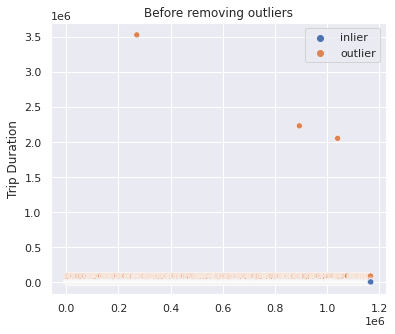

In [ ]:
# x-axis values
x_values = range(trainDF.trip_duration.shape[0])

# y-axis values
y_values = trainDF.trip_duration

plotWithOutliers = sns.scatterplot(data=y_values,
                                   y=y_values,
                                   x=x_values,
                                   hue=is_outlier).set(title="Before removing outliers",
                                                       ylabel = "Trip Duration")


All inliers are below value ≈ 11627 so we can barely notice them in this plot with some very large outliers

In [ ]:
# Now let's remove all rows with trip duration outliers
trainDF = trainDF.drop(trainDF[trainDF.trip_duration > upperOutlier].index)
trainDF = trainDF.drop(trainDF[trainDF.trip_duration < lowerOutlier].index)

# Print the new statistics
newStatistics = trainDF.describe()
newTripDurMean = newStatistics["trip_duration"]["mean"]
newTripDurStd = newStatistics["trip_duration"]["std"]
newStatistics

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.165250e+06,1.165250e+06,1.165250e+06,1.165250e+06,1.165250e+06,1.165250e+06,1.165250e+06
mean,1.534260e+00,1.664723e+00,-7.397346e+01,4.075090e+01,-7.397340e+01,4.075182e+01,8.370149e+02
std,4.988251e-01,1.314119e+00,6.230739e-02,3.170862e-02,6.159180e-02,3.645359e-02,6.590678e+02
min,1.000000e+00,0.000000e+00,-1.219332e+02,3.435970e+01,-1.219332e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399186e+01,4.073732e+01,-7.399133e+01,4.073592e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398175e+01,4.075408e+01,-7.397977e+01,4.075453e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076835e+01,-7.396303e+01,4.076981e+01,1.073000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,4.437194e+01,-6.133553e+01,4.392103e+01,1.155600e+04


In [ ]:
# Compute new outliers
newUpperOutlier = tripDurMean+2*tripDurStd
newLowerOutlier = tripDurMean-2*tripDurStd

new_is_outlier = np.where((trainDF.trip_duration >= newUpperOutlier) | (trainDF.trip_duration <= newLowerOutlier),"outlier","inlier")

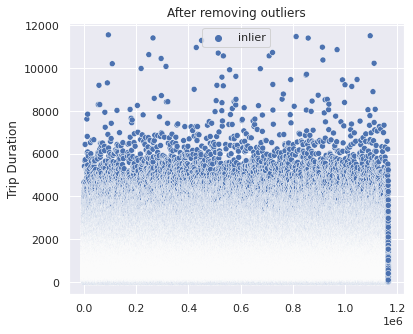

In [ ]:
# x-axis values
x_values = range(trainDF.trip_duration.shape[0])

# y-axis values
y_values = trainDF.trip_duration

plotWithOutliers = sns.scatterplot(data=y_values,
                                   y=y_values,
                                   x=x_values,
                                   hue=new_is_outlier).set(title="After removing outliers",
                                                       ylabel = "Trip Duration")

After removing outliers we notice there is none left in the graph.

##*2. Remove any points outside NY*

In [ ]:
# NY longitude border is (-74.03, -73.75) and latitude border is (40.63, 40.85)
minLongBorder = -74.03
maxLongBorder = -73.75
minLatBorder = 40.63
maxLatBorder = 40.85

# Minimum and maximum values before removal
min_pickupLong = min(trainDF.pickup_longitude)
max_pickupLong = max(trainDF.pickup_longitude)
min_dropoffLong = min(trainDF.dropoff_longitude)
max_dropoffLong = max(trainDF.dropoff_longitude)

min_pickupLat = min(trainDF.pickup_latitude)
max_pickupLat = max(trainDF.pickup_latitude)
min_dropoffLat = min(trainDF.dropoff_latitude)
max_dropoffLat = max(trainDF.dropoff_latitude)

trainDF.shape

(1165250, 11)

In [ ]:
trainDF = trainDF.drop(trainDF[trainDF.pickup_longitude < minLongBorder].index)
trainDF = trainDF.drop(trainDF[trainDF.pickup_longitude > maxLongBorder].index)
trainDF = trainDF.drop(trainDF[trainDF.dropoff_longitude < minLongBorder].index)
trainDF = trainDF.drop(trainDF[trainDF.dropoff_longitude > maxLongBorder].index)

trainDF = trainDF.drop(trainDF[trainDF.pickup_latitude < minLatBorder].index)
trainDF = trainDF.drop(trainDF[trainDF.pickup_latitude > maxLatBorder].index)
trainDF = trainDF.drop(trainDF[trainDF.dropoff_latitude < minLatBorder].index)
trainDF = trainDF.drop(trainDF[trainDF.dropoff_latitude > maxLatBorder].index)


In [ ]:
# Minimum and maximum values after removal
new_min_pickupLong = min(trainDF.pickup_longitude)
new_max_pickupLong = max(trainDF.pickup_longitude)
new_min_dropoffLong = min(trainDF.dropoff_longitude)
new_max_dropoffLong = max(trainDF.dropoff_longitude)

new_min_pickupLat = min(trainDF.pickup_latitude)
new_max_pickupLat = max(trainDF.pickup_latitude)
new_min_dropoffLat = min(trainDF.dropoff_latitude)
new_max_dropoffLat = max(trainDF.dropoff_latitude)

trainDF.shape

(1149734, 11)

In [ ]:
sns.set(rc={'figure.figsize':(6,4)})

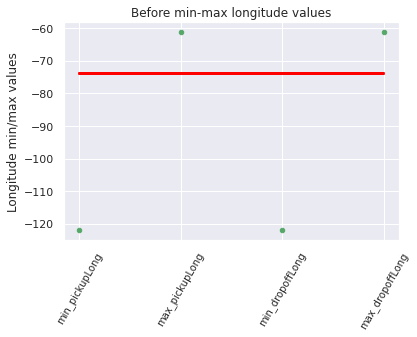

In [ ]:
# Now lets plot before min-max longitude values
x_coordinates = ["min_pickupLong", "max_pickupLong", "min_dropoffLong", 
                 "max_dropoffLong"]
y_coordinates = [min_pickupLong, max_pickupLong, min_dropoffLong,
                 max_dropoffLong]

plt.scatter(x_coordinates, y_coordinates, color='g', s=20)
plt.xticks(rotation = 60, fontsize=10)
plt.ylabel('Longitude min/max values')
plt.title('Before min-max longitude values')
plot_long = plt.plot([0, 3], [minLongBorder, minLongBorder], linewidth=2, color="red")
plot_long = plt.plot([0, 3], [maxLongBorder, maxLongBorder], linewidth=2, color="red")


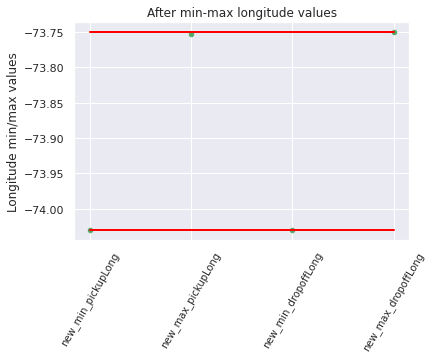

In [ ]:
# Now lets plot after min-max longitude values
x_coordinates = ["new_min_pickupLong", "new_max_pickupLong",
                 "new_min_dropoffLong", "new_max_dropoffLong"]
y_coordinates = [new_min_pickupLong, new_max_pickupLong,
                 new_min_dropoffLong, new_max_dropoffLong]

plt.scatter(x_coordinates, y_coordinates, color='g', s=20)
plt.xticks(rotation = 60, fontsize=10)
plt.ylabel('Longitude min/max values')
plt.title('After min-max longitude values')
plot_long = plt.plot([0, 3], [minLongBorder, minLongBorder], linewidth=2, color="red")
plot_long = plt.plot([0, 3], [maxLongBorder, maxLongBorder], linewidth=2, color="red")
                

The red lines represent the longitude limits of NY. At first the min/max values surpassed these limits by far, so we can barely distinguish the two lines, but after cleaning the new min/max values are within the borders thus we only kept travels strictly inside NY. Same applies for latitude.

##*3. Date time analysis*

### Preprocessing

In [ ]:
# Convert date string to timestamp for both train and test datasets
trainDF["pickup_datetime"] =  pd.to_datetime(trainDF["pickup_datetime"], infer_datetime_format=True)
trainDF["dropoff_datetime"] =  pd.to_datetime(trainDF["dropoff_datetime"], infer_datetime_format=True)
testDF["pickup_datetime"] =  pd.to_datetime(testDF["pickup_datetime"], infer_datetime_format=True)

In [ ]:
# We 'll use these functions to create a few time related columns

def create_day_period(datetime):
  if (datetime.hour >= 6) & (datetime.hour <= 11):
    return "Morning"
  elif (datetime.hour >= 12) & (datetime.hour <= 15):
    return "Afternoon"
  elif (datetime.hour >= 16) & (datetime.hour <= 21):
    return "Evening"
  else:
    return "Late Night"

def create_day_name(datetime):
  return datetime.day_name()

def create_month(datetime):
  if (datetime.month == 1):
    return "January"
  elif (datetime.month == 2):
    return "February"
  elif (datetime.month == 3):
    return "March"
  elif (datetime.month == 4):
    return "April"
  elif (datetime.month == 5):
    return "May"
  elif (datetime.month == 6):
    return "June"
  elif (datetime.month == 7):
    return "July"
  elif (datetime.month == 8):
    return "August"
  elif (datetime.month == 9):
    return "September"
  elif (datetime.month == 10):
    return "Octomber"
  elif (datetime.month == 11):
    return "November"
  elif (datetime.month == 12):
    return "December"
  return datetime.month

def create_hour(datetime):
  return datetime.hour

def create_year(datetime):
  return datetime.year

def create_season(datetime):
  if (datetime.month >= 3) & (datetime.month <= 5):
    return "Spring"
  if (datetime.month >= 6) & (datetime.month <= 8):
    return "Summer"
  if (datetime.month >= 9) & (datetime.month <= 11):
    return "Autumn"
  else:
    return "Winter"


In [ ]:
# Adding day period columns
trainDF["pickup_day_period"] = trainDF["pickup_datetime"].apply(lambda datetime: create_day_period(datetime))
trainDF["dropoff_day_period"] = trainDF["dropoff_datetime"].apply(lambda datetime: create_day_period(datetime))
testDF["pickup_day_period"] = testDF["pickup_datetime"].apply(lambda datetime: create_day_period(datetime))

# Adding day name columns
trainDF["pickup_day_name"] = trainDF["pickup_datetime"].apply(lambda datetime: create_day_name(datetime))
trainDF["dropoff_day_name"] = trainDF["dropoff_datetime"].apply(lambda datetime: create_day_name(datetime))
testDF["pickup_day_name"] = testDF["pickup_datetime"].apply(lambda datetime: create_day_name(datetime))

# Adding month columns
trainDF["pickup_month"] = trainDF["pickup_datetime"].apply(lambda datetime: create_month(datetime))
trainDF["dropoff_month"] = trainDF["dropoff_datetime"].apply(lambda datetime: create_month(datetime))
testDF["pickup_month"] = testDF["pickup_datetime"].apply(lambda datetime: create_month(datetime))

# Adding hour columns
trainDF["pickup_hour"] = trainDF["pickup_datetime"].apply(lambda datetime: create_hour(datetime))
trainDF["dropoff_hour"] = trainDF["dropoff_datetime"].apply(lambda datetime: create_hour(datetime))
testDF["pickup_hour"] = testDF["pickup_datetime"].apply(lambda datetime: create_hour(datetime))

# Adding year columns
trainDF["pickup_year"] = trainDF["pickup_datetime"].apply(lambda datetime: create_year(datetime))
trainDF["dropoff_year"] = trainDF["dropoff_datetime"].apply(lambda datetime: create_year(datetime))
testDF["pickup_year"] = testDF["pickup_datetime"].apply(lambda datetime: create_year(datetime))


# Adding season columns
trainDF["pickup_season"] = trainDF["pickup_datetime"].apply(lambda datetime: create_season(datetime))
trainDF["dropoff_season"] = trainDF["dropoff_datetime"].apply(lambda datetime: create_season(datetime))
testDF["pickup_season"] = testDF["pickup_datetime"].apply(lambda datetime: create_season(datetime))


### Most busy pickup days

In [ ]:
sns.set(rc={'figure.figsize':(10,4)})

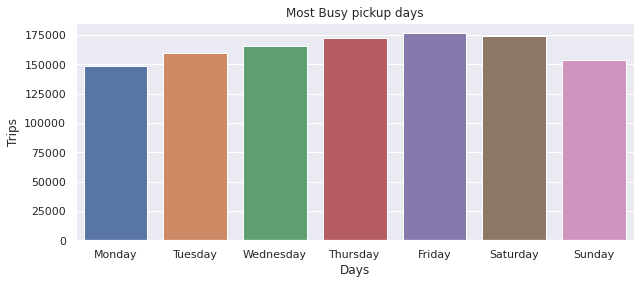

In [ ]:
pDaysDict = {}
pDaysDict['Monday'] = trainDF[trainDF.pickup_day_name == "Monday"].shape[0]
pDaysDict['Tuesday'] = trainDF[trainDF.pickup_day_name == "Tuesday"].shape[0]
pDaysDict['Wednesday'] = trainDF[trainDF.pickup_day_name == "Wednesday"].shape[0]
pDaysDict['Thursday'] = trainDF[trainDF.pickup_day_name == "Thursday"].shape[0]
pDaysDict['Friday'] = trainDF[trainDF.pickup_day_name == "Friday"].shape[0]
pDaysDict['Saturday'] = trainDF[trainDF.pickup_day_name == "Saturday"].shape[0]
pDaysDict['Sunday'] = trainDF[trainDF.pickup_day_name == "Sunday"].shape[0]



busypDaysPlot = sns.barplot(x=list(pDaysDict.keys()),
                           y=list(pDaysDict.values())).set(title='Most Busy pickup days')

plt.xlabel("Days")
plt.ylabel("Trips")

plt.show(busypDaysPlot)


### Most busy dropoff days

In [ ]:
sns.set(rc={'figure.figsize':(10,4)})

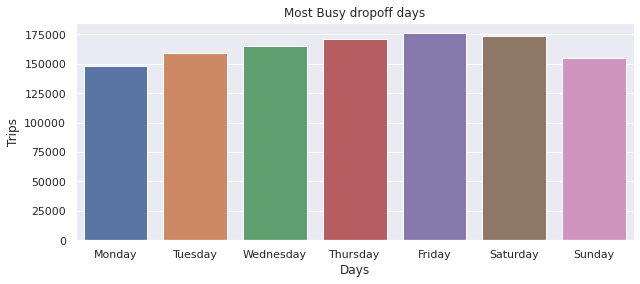

In [ ]:
dDaysDict = {}
dDaysDict['Monday'] = trainDF[trainDF.dropoff_day_name == "Monday"].shape[0]
dDaysDict['Tuesday'] = trainDF[trainDF.dropoff_day_name == "Tuesday"].shape[0]
dDaysDict['Wednesday'] = trainDF[trainDF.dropoff_day_name == "Wednesday"].shape[0]
dDaysDict['Thursday'] = trainDF[trainDF.dropoff_day_name == "Thursday"].shape[0]
dDaysDict['Friday'] = trainDF[trainDF.dropoff_day_name == "Friday"].shape[0]
dDaysDict['Saturday'] = trainDF[trainDF.dropoff_day_name == "Saturday"].shape[0]
dDaysDict['Sunday'] = trainDF[trainDF.dropoff_day_name == "Sunday"].shape[0]



busydDaysPlot = sns.barplot(x=list(dDaysDict.keys()),
                           y=list(dDaysDict.values())).set(title='Most Busy dropoff days')

plt.xlabel("Days")
plt.ylabel("Trips")

plt.show(busydDaysPlot)


### Trips per day period

In [ ]:
sns.set(rc={'figure.figsize':(12,4)})

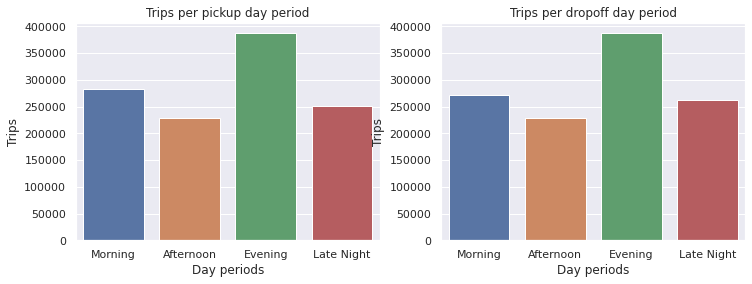

In [ ]:
pDayPeriodDict = {}
pDayPeriodDict['Morning'] = trainDF[trainDF.pickup_day_period == "Morning"].shape[0]
pDayPeriodDict['Afternoon'] = trainDF[trainDF.pickup_day_period == "Afternoon"].shape[0]
pDayPeriodDict['Evening'] = trainDF[trainDF.pickup_day_period == "Evening"].shape[0]
pDayPeriodDict['Late Night'] = trainDF[trainDF.pickup_day_period == "Late Night"].shape[0]

dDayPeriodDict = {}
dDayPeriodDict['Morning'] = trainDF[trainDF.dropoff_day_period == "Morning"].shape[0]
dDayPeriodDict['Afternoon'] = trainDF[trainDF.dropoff_day_period == "Afternoon"].shape[0]
dDayPeriodDict['Evening'] = trainDF[trainDF.dropoff_day_period == "Evening"].shape[0]
dDayPeriodDict['Late Night'] = trainDF[trainDF.dropoff_day_period == "Late Night"].shape[0]

fig, ax = plt.subplots(1,2)
pDayPeriodPlot = sns.barplot(x=list(pDayPeriodDict.keys()),
                             y=list(pDayPeriodDict.values()),
                             ax=ax[0]).set(title='Trips per pickup day period')
dDayPeriodPlot = sns.barplot(x=list(dDayPeriodDict.keys()),
                             y=list(dDayPeriodDict.values()),
                             ax=ax[1]).set(title='Trips per dropoff day period')

for ax in fig.axes:
  plt.sca(ax)
  plt.xlabel("Day periods")
  plt.ylabel("Trips")

fig.show()

### Trips per month

In [ ]:
sns.set(rc={'figure.figsize':(12,4)})


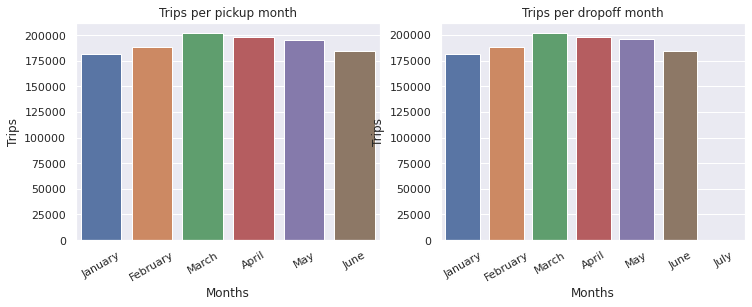

In [ ]:
pMonthDict = {}
pMonthDict['January'] = 0
pMonthDict['February'] = 0
pMonthDict['March'] = 0
pMonthDict['April'] = 0
pMonthDict['May'] = 0
pMonthDict['June'] = 0
pMonthDict['July'] = 0
pMonthDict['August'] = 0
pMonthDict['September'] = 0
pMonthDict['Octomber'] = 0
pMonthDict['November'] = 0
pMonthDict['December'] = 0

ptempDict = dict(trainDF['pickup_month'].value_counts())
pMonthDict.update(ptempDict)
pMonthDict = {k: v for k, v in pMonthDict.items() if v!=0}


dMonthDict = {}
dMonthDict['January'] = 0
dMonthDict['February'] = 0
dMonthDict['March'] = 0
dMonthDict['April'] = 0
dMonthDict['May'] = 0
dMonthDict['June'] = 0
dMonthDict['July'] = 0
dMonthDict['August'] = 0
dMonthDict['September'] = 0
dMonthDict['Octomber'] = 0
dMonthDict['November'] = 0
dMonthDict['December'] = 0

dtempDict = dict(trainDF['dropoff_month'].value_counts())
dMonthDict.update(dtempDict)
dMonthDict = {k: v for k, v in dMonthDict.items() if v!=0}

fig, ax = plt.subplots(1,2)

pMonthPlot = sns.barplot(x=list(pMonthDict.keys()),
                             y=list(pMonthDict.values()),
                             ax=ax[0]).set(title='Trips per pickup month')

dMonthPlot = sns.barplot(x=list(dMonthDict.keys()),
                             y=list(dMonthDict.values()),
                             ax=ax[1]).set(title='Trips per dropoff month')


for ax in fig.axes:
  plt.sca(ax)
  plt.xticks(rotation=30)
  plt.xlabel("Months")
  plt.ylabel("Trips")

fig.show()

### Average travel time by pickup hour

In [ ]:
sns.set(rc={'figure.figsize':(11,4)})


In [ ]:
groupedPickupHours = trainDF.groupby(["pickup_hour"])
avgPickupHours = dict(groupedPickupHours["trip_duration"].mean())

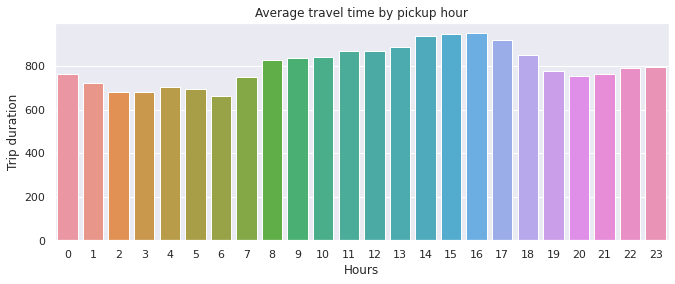

In [ ]:
pickupHourPlot = sns.barplot(x=list(avgPickupHours.keys()),
                           y=list(avgPickupHours.values())).set(title='Average travel time by pickup hour')

plt.xlabel("Hours")
plt.ylabel("Trip duration")
plt.show(pickupHourPlot)

### Average travel time by day period

In [ ]:
avgDayPeriods = {}
avgDayPeriods['Morning'] = 0
avgDayPeriods['Afternoon'] = 0
avgDayPeriods['Evening'] = 0
avgDayPeriods['Late Night'] = 0

groupedDayPeriods = trainDF.groupby(["pickup_day_period"])
tempAvgDayPeriods = dict(groupedDayPeriods["trip_duration"].mean())
avgDayPeriods.update(tempAvgDayPeriods)

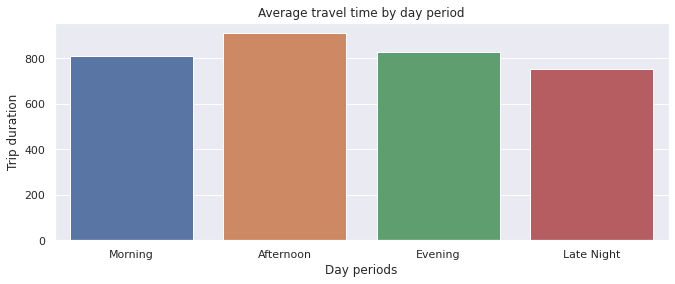

In [ ]:
dayPeriodPlot = sns.barplot(x=list(avgDayPeriods.keys()),
                           y=list(avgDayPeriods.values())).set(title='Average travel time by day period')

plt.xlabel("Day periods")
plt.ylabel("Trip duration")
plt.show(dayPeriodPlot)

### Average travel time by day of week

In [ ]:
avgDays = {}
avgDays['Monday'] = 0
avgDays['Tuesday'] = 0
avgDays['Wednesday'] = 0
avgDays['Thursday'] = 0
avgDays['Friday'] = 0
avgDays['Saturday'] = 0
avgDays['Sunday'] = 0

groupedDays = trainDF.groupby(["pickup_day_name"])
tempAvgDays = dict(groupedDays["trip_duration"].mean())
avgDays.update(tempAvgDays)

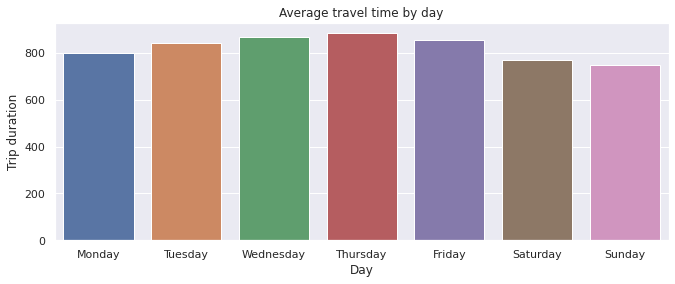

In [ ]:
daysPlot = sns.barplot(x=list(avgDays.keys()),
                           y=list(avgDays.values())).set(title='Average travel time by day')

plt.xlabel("Day")
plt.ylabel("Trip duration")
plt.show(daysPlot)

### Conclusions

> We can see that people use transport vendors mostly by the end of the week (Thursday, Friday, Saturday) in the evening. This could happen due to the tiredness of their everyday jobs and the need to get home more relaxed and faster, thus avoiding buses or the subway.

> Travel time is increased in the afternoon around 4 to 5 pm probably due to the heavy traffic around these hours.

##*4. Trip duration log transformation*

In [ ]:
sns.set(rc={'figure.figsize':(10,4)})


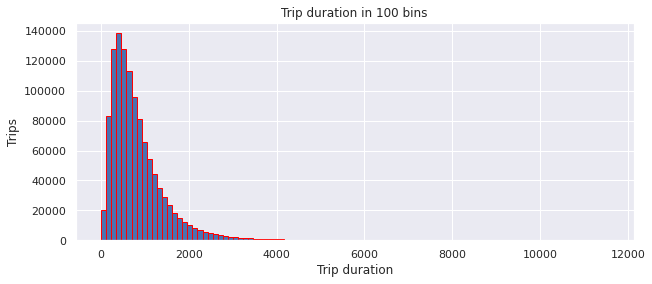

In [ ]:
tripDurPlot = plt.hist(trainDF.trip_duration, edgecolor="red", bins=100)
plt.xlabel("Trip duration")
plt.ylabel("Trips")
plt.title("Trip duration in 100 bins")
plt.show()

In [ ]:
trainDF["log_trip_duration"] = np.log(trainDF["trip_duration"])

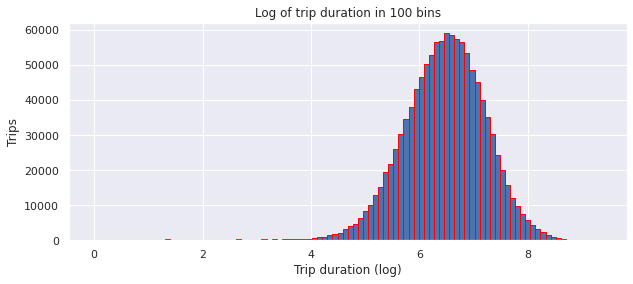

In [ ]:
tripLogDurPlot = plt.hist(trainDF.log_trip_duration, edgecolor="red", bins=100)
plt.xlabel("Trip duration (log)")
plt.ylabel("Trips")
plt.title("Log of trip duration in 100 bins")
plt.show()

##*5. Average travel time by vendor*

In [ ]:
sns.set(rc={'figure.figsize':(4,4)})


In [ ]:
groupedVendors = trainDF.groupby(["vendor_id"])
avgVendors = dict(groupedVendors["trip_duration"].mean())

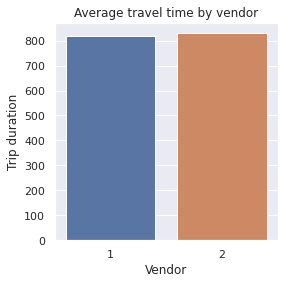

In [ ]:
vendorPlot = sns.barplot(x=list(avgVendors.keys()),
                           y=list(avgVendors.values())).set(title='Average travel time by vendor')

plt.xlabel("Vendor")
plt.ylabel("Trip duration")
plt.show(vendorPlot)

##*6. Average travel time by number of passengers*

In [ ]:
sns.set(rc={'figure.figsize':(9,4)})


In [ ]:
groupedPassengerCount = trainDF.groupby(["passenger_count"])
avgPassengerCount = dict(groupedPassengerCount["trip_duration"].mean())

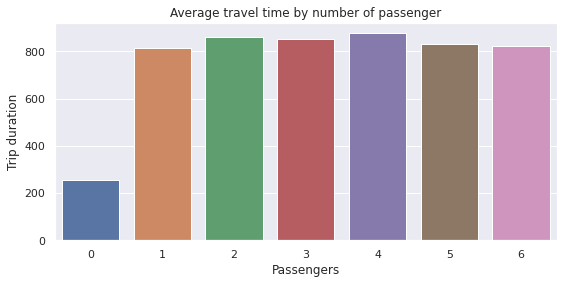

In [ ]:
passengerCountPlot = sns.barplot(x=list(avgPassengerCount.keys()),
                           y=list(avgPassengerCount.values())).set(title='Average travel time by number of passenger')

plt.xlabel("Passengers")
plt.ylabel("Trip duration")
plt.show(passengerCountPlot)

We don't notice any big inpact on trip duration caused by increasing passenger number.

##*7. Distance between points*

In [ ]:
# Create a new column containing the Manhattan distance between pickup and
# dropoff points
trainDF["distance"] = trainDF.apply(lambda row: cityblock([row.pickup_longitude,row.pickup_latitude],
                                                          [row.dropoff_longitude,row.dropoff_latitude]), axis = 1)

testDF["distance"] = testDF.apply(lambda row: cityblock([row.pickup_longitude,row.pickup_latitude],
                                                          [row.dropoff_longitude,row.dropoff_latitude]), axis = 1)

### Average travel distance by day of week

In [ ]:
avgTDDays = {}
avgTDDays['Monday'] = 0
avgTDDays['Tuesday'] = 0
avgTDDays['Wednesday'] = 0
avgTDDays['Thursday'] = 0
avgTDDays['Friday'] = 0
avgTDDays['Saturday'] = 0
avgTDDays['Sunday'] = 0

groupedDays = trainDF.groupby(["pickup_day_name"])
tempAvgTDDays = dict(groupedDays["distance"].mean())
avgTDDays.update(tempAvgTDDays)

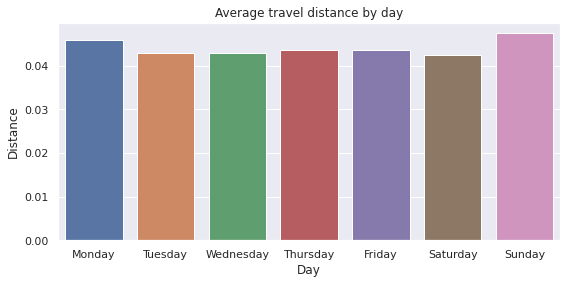

In [ ]:
TDdaysPlot = sns.barplot(x=list(avgTDDays.keys()),
                           y=list(avgTDDays.values())).set(title='Average travel distance by day')

plt.xlabel("Day")
plt.ylabel("Distance")
plt.show(TDdaysPlot)

### Travel time and distance

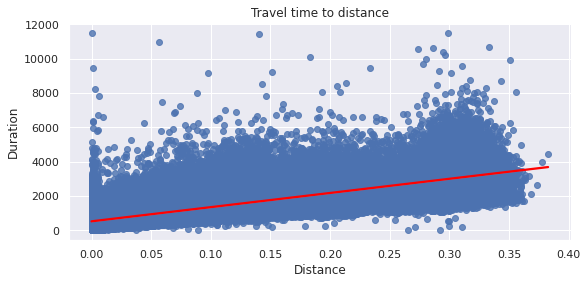

In [ ]:
timeDist = dict(zip(trainDF.distance, trainDF.trip_duration))

y_values=list(timeDist.values())
x_values=list(timeDist.keys())
timeDistPlot = sns.regplot(y=y_values,
                           x=x_values,
                           line_kws={"color": "red"}).set(title="Travel time to distance",
                                                       ylabel = "Duration",
                                                       xlabel = "Distance")


We can see the logical increase in trip duration the bigger the trip distance gets.

##*8. Average speed*

In [ ]:
trainDF["average_speed"] = trainDF["distance"]/trainDF["trip_duration"]

### Average speed by hour

In [ ]:
sns.set(rc={'figure.figsize':(11,4)})


In [ ]:
groupedPickupHours = trainDF.groupby(["pickup_hour"])
avgSpeedPickupHours = dict(groupedPickupHours["average_speed"].mean())

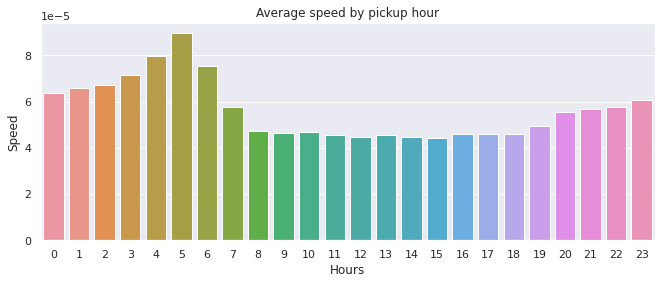

In [ ]:
speedHourPlot = sns.barplot(x=list(avgSpeedPickupHours.keys()),
                           y=list(avgSpeedPickupHours.values())).set(title='Average speed by pickup hour')

plt.xlabel("Hours")
plt.ylabel("Speed")
plt.show(speedHourPlot)

### Average speed by day of week

In [ ]:
avgSDays = {}
avgSDays['Monday'] = 0
avgSDays['Tuesday'] = 0
avgSDays['Wednesday'] = 0
avgSDays['Thursday'] = 0
avgSDays['Friday'] = 0
avgSDays['Saturday'] = 0
avgSDays['Sunday'] = 0

groupedDays = trainDF.groupby(["pickup_day_name"])
tempAvgSDays = dict(groupedDays["average_speed"].mean())
avgSDays.update(tempAvgSDays)

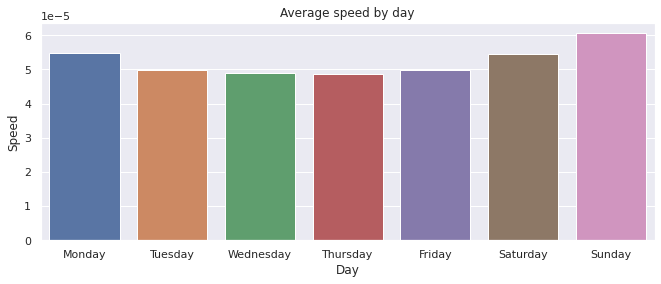

In [ ]:
SdaysPlot = sns.barplot(x=list(avgSDays.keys()),
                           y=list(avgSDays.values())).set(title='Average speed by day')

plt.xlabel("Day")
plt.ylabel("Speed")
plt.show(SdaysPlot)

### Average speed by month

In [ ]:
avgSMonths = {}
avgSMonths['January'] = 0
avgSMonths['February'] = 0
avgSMonths['March'] = 0
avgSMonths['April'] = 0
avgSMonths['May'] = 0
avgSMonths['June'] = 0
avgSMonths['July'] = 0
avgSMonths['August'] = 0
avgSMonths['September'] = 0
avgSMonths['Octomber'] = 0
avgSMonths['November'] = 0
avgSMonths['December'] = 0

groupedMonths = trainDF.groupby(["pickup_month"])
tempAvgSMonths = dict(groupedMonths["average_speed"].mean())
avgSMonths.update(tempAvgSMonths)

avgSMonths = {k: v for k, v in avgSMonths.items() if v!=0}

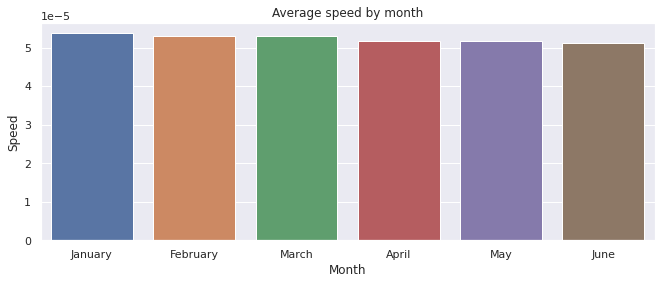

In [ ]:
SmonthsPlot = sns.barplot(x=list(avgSMonths.keys()),
                           y=list(avgSMonths.values())).set(title='Average speed by month')

plt.xlabel("Month")
plt.ylabel("Speed")
plt.show(SmonthsPlot)

We notice that speed is less on the weekdays in morning and afternoon probably due to heavy traffic.

##*9. Graphs for pickup/dropoff points*

In [ ]:
sns.set(rc={'figure.figsize':(12,4)})

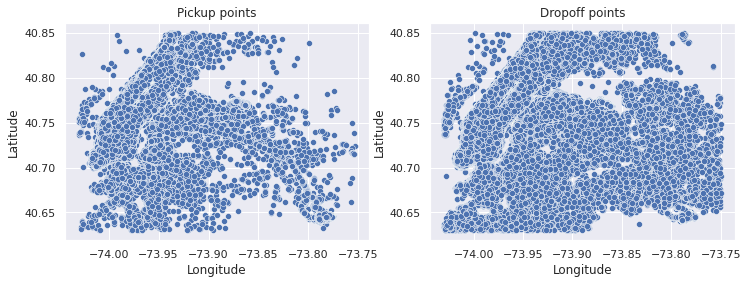

In [ ]:
y1_values=list(trainDF["pickup_latitude"])
x1_values=list(trainDF["pickup_longitude"])

y2_values=list(trainDF["dropoff_latitude"])
x2_values=list(trainDF["dropoff_longitude"])

fig, ax =plt.subplots(1,2)

pickupPoints = sns.scatterplot(y=y1_values,
                                   x=x1_values,ax=ax[0]).set(title="Pickup points",
                                                       ylabel = "Latitude",
                                                       xlabel = "Longitude")

dropoffPoints = sns.scatterplot(y=y2_values,
                                   x=x2_values,ax=ax[1]).set(title="Dropoff points",
                                                       ylabel = "Latitude",
                                                       xlabel = "Longitude")                                   

# **Save/Load processed Datafiles**

In [ ]:
# Paths
trainDF_FilePath = "./drive/MyDrive/ColabNotebooks/travel_time_data/trainDF.pkl"
testDF_FilePath = "./drive/MyDrive/ColabNotebooks/travel_time_data/testDF.pkl"
targetDF_FilePath = "./drive/MyDrive/ColabNotebooks/travel_time_data/targetDF.pkl"


# # Save
# pickle.dump(trainDF, open(trainDF_FilePath, 'wb'))
# pickle.dump(testDF, open(testDF_FilePath, 'wb'))
# pickle.dump(targetDF, open(targetDF_FilePath, 'wb'))

# Load from disk
trainDF = pickle.load(open(trainDF_FilePath, 'rb'))
testDF = pickle.load(open(testDF_FilePath, 'rb'))
targetDF = pickle.load(open(targetDF_FilePath, 'rb'))


# **Clustering**


> We'll now perform clustering using the k-means algorithm for the pickup points of our train dataset. By using the elbow method we try to compute the best number of clusters to use. We fit and plot the results.


In [ ]:
pointsList = list(zip(trainDF.pickup_longitude, trainDF.pickup_latitude))

In [ ]:
scaler = StandardScaler()
scaled_features = scaler.fit_transform(pointsList)

In [ ]:
# Using the elbow method
kMax = 10
sse = []
for k in range(1, kMax):
  kmeans = KMeans(n_clusters=k)
  kmeans.fit(scaled_features)
  sse.append(kmeans.inertia_)

In [ ]:
sns.set(rc={'figure.figsize':(7,4)})

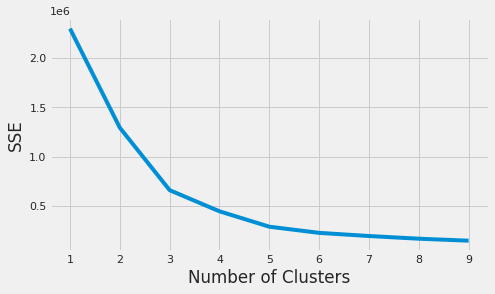

In [ ]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, kMax), sse)
plt.xticks(range(1, kMax))
plt.xlabel("Number of Clusters")
plt.ylabel("SSE")
plt.show()

In [ ]:
# We can see in the graph the best value for number of clusters is 3
k = 3
kmeans = KMeans(n_clusters=k, random_state=42).fit(pointsList)

In [ ]:
sns.set(rc={'figure.figsize':(5,4)})

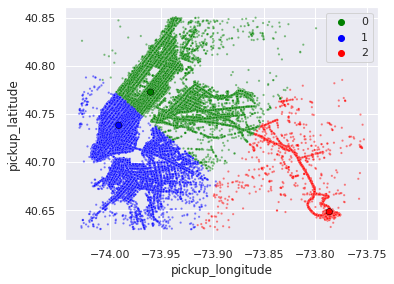

In [ ]:
y1_values = trainDF["pickup_latitude"]
x1_values = trainDF["pickup_longitude"]


colors = ['green', 'blue', 'red']
ax = sns.scatterplot(y=y1_values, x=x1_values, hue=kmeans.labels_, palette=colors, alpha=0.5, s=5)
ax = sns.scatterplot(x=kmeans.cluster_centers_[:, 0], y=kmeans.cluster_centers_[:, 1],
                     hue=range(k), palette=colors, s=40, ec='black', legend=False, ax=ax)
plt.show()


# **Travel time prediction with Random Forest Regressor**


> In this part we use the random forest regressor to predict the logarithmic trip duration we computed previously. With *feature_importances_* from sklearn we try to compute the most important features to include in our model. Then by using *GridSearchCV* we find better parameters to train the regressor and finally examine the predictions.


In [ ]:
# We can choose a subset of our train-test dataset to train and predict
percentage = 100
train = select_dfsubset(trainDF,percentage)
print("Chosen number of travels is {} - {}% of the given train-dataset.".format(train.shape[0], percentage))
test = select_dfsubset(testDF,percentage)
print("Chosen number of travels is {} - {}% of the given test-dataset.".format(test.shape[0], percentage))
target = select_dfsubset(targetDF,percentage)
print("Chosen number of travels is {} - {}% of the given target-dataset.".format(target.shape[0], percentage))

Chosen number of travels is 1149734 - 100% of the given train-dataset.
Chosen number of travels is 291729 - 100% of the given test-dataset.
Chosen number of travels is 291729 - 100% of the given target-dataset.


##*Preprocessing datasets for fitting*

In [ ]:
# First we'll drop any columns-features we won't use
train = train.drop(columns = ["id", "pickup_datetime", "dropoff_datetime",
                      "store_and_fwd_flag", "trip_duration",
                      "dropoff_day_period", "dropoff_day_name",
                      "dropoff_month", "dropoff_hour", "pickup_year",
                      "dropoff_year", "dropoff_season", "average_speed"])

test = test.drop(columns = ["id", "pickup_datetime", "store_and_fwd_flag", 
                            "pickup_year"])

# Before we drop columns on target dataset we need to log-transform
# the trip_duration column
target["log_trip_duration"] = np.log(target["trip_duration"])
target = target.drop(columns = ["id", "trip_duration"])

In [ ]:
# Then we encode any columns with strings so we can fit
le = preprocessing.LabelEncoder()
for col in train.columns:
  if train[col].dtype == object:
    train[col] = le.fit_transform(train[col])
  else:
    pass
for col in test.columns:
  if test[col].dtype == object:
    test[col] = le.fit_transform(test[col])
  else:
    pass

In [ ]:
X_train, y_train = train.drop(columns = "log_trip_duration"), train["log_trip_duration"]
X_test, y_test = test, target["log_trip_duration"]

print(X_train.shape, len(y_train), X_test.shape, len(y_test))

(1149734, 12) 1149734 (291729, 12) 291729


##*Most important features*

In [ ]:
# We will choose a subset of X_train, y_train to fit and find
# most important features
percentage = 20
subX_train = select_dfsubset(X_train,percentage)
print("Chosen number of travels is {} - {}% of the given x_train-dataset.".format(subX_train.shape[0], percentage))
suby_train = select_dfsubset(y_train,percentage)
print("Chosen number of travels is {} - {}% of the given y_train-dataset.".format(suby_train.shape[0], percentage))


Chosen number of travels is 229946 - 20% of the given x_train-dataset.
Chosen number of travels is 229946 - 20% of the given t_train-dataset.


In [ ]:
featImportances_RF = RandomForestRegressor(random_state=0)
featImportances_RF.fit(subX_train, suby_train)

RandomForestRegressor(random_state=0)

In [ ]:
start_time = time.time()
importances = featImportances_RF.feature_importances_
std = np.std([tree.feature_importances_ for tree in featImportances_RF.estimators_], axis=0)
elapsed_time = time.time() - start_time

print(f"Elapsed time to compute the importances: {elapsed_time:.3f} seconds")

Elapsed time to compute the importances: 1.144 seconds


In [ ]:
sns.set(rc={'figure.figsize':(7,3)})


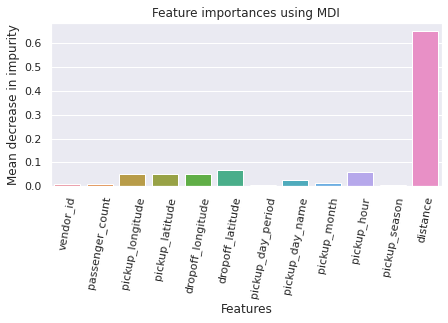

In [ ]:
forest_importances = pd.Series(importances, index=X_train.columns)

forestImportancesPlot = sns.barplot(x=list(X_train.columns),
                           y=list(forest_importances)).set(title='Feature importances using MDI')

plt.xlabel("Features")
plt.ylabel("Mean decrease in impurity")
plt.xticks(rotation=80)
plt.show(forestImportancesPlot)


In [ ]:
# Finally let's keep only the first six most important features
# and drop the others
X_train = X_train.drop(columns = ["vendor_id", "passenger_count",
                      "pickup_day_period", "pickup_day_name",
                      "pickup_month", "pickup_season"])

X_test = X_test.drop(columns = ["vendor_id", "passenger_count",
                      "pickup_day_period", "pickup_day_name",
                      "pickup_month", "pickup_season"])

## *Save/Load final X,y datasets*

In [ ]:
# Paths
X_train_FilePath = "./drive/MyDrive/ColabNotebooks/travel_time_data/X_train.pkl"
y_train_FilePath = "./drive/MyDrive/ColabNotebooks/travel_time_data/y_train.pkl"
X_test_FilePath = "./drive/MyDrive/ColabNotebooks/travel_time_data/X_test.pkl"
y_test_FilePath = "./drive/MyDrive/ColabNotebooks/travel_time_data/y_test.pkl"


# # Save
# pickle.dump(X_train, open(X_train_FilePath, 'wb'))
# pickle.dump(y_train, open(y_train_FilePath, 'wb'))
# pickle.dump(X_test, open(X_test_FilePath, 'wb'))
# pickle.dump(y_test, open(y_test_FilePath, 'wb'))


# Load from disk
X_train = pickle.load(open(X_train_FilePath, 'rb'))
y_train = pickle.load(open(y_train_FilePath, 'rb'))
X_test = pickle.load(open(X_test_FilePath, 'rb'))
y_test = pickle.load(open(y_test_FilePath, 'rb'))


##*Random forest regressor fit/predict*

###*Training a model with **default** parameters on full dataset*

In [ ]:
# First we train a model with default-basic parameter values
default_RF = RandomForestRegressor(max_depth=2, random_state=0)
default_RF.fit(X_train, y_train)
default_RF_results = default_RF.predict(X_test)

In [ ]:
defaultMae = mae(default_RF_results,y_test)
defaultMae

0.3980752784040778

In [ ]:
defaultMse = mse(default_RF_results,y_test)
defaultMse

0.3118361083879592

###*Find better parameter values with Grid Search*

In [ ]:
# We will choose a subset of X,y datasets to use with Grid Search
# and find better parameter values
percentage = 5
GSsubX_train = select_dfsubset(X_train,percentage)
print("Chosen number of travels is {} - {}% of the given x_train-dataset.".format(GSsubX_train.shape[0], percentage))
GSsuby_train = select_dfsubset(y_train,percentage)
print("Chosen number of travels is {} - {}% of the given y_train-dataset.".format(GSsuby_train.shape[0], percentage))

GSsubX_test = select_dfsubset(X_test,percentage)
print("Chosen number of travels is {} - {}% of the given X_test-dataset.".format(GSsubX_test.shape[0], percentage))
GSsuby_test = select_dfsubset(y_test,percentage)
print("Chosen number of travels is {} - {}% of the given y_test-dataset.".format(GSsuby_test.shape[0], percentage))


Chosen number of travels is 57486 - 5% of the given x_train-dataset.
Chosen number of travels is 57486 - 5% of the given y_train-dataset.
Chosen number of travels is 14586 - 5% of the given X_test-dataset.
Chosen number of travels is 14586 - 5% of the given y_test-dataset.


In [ ]:
param_grid = {'max_depth': [5, 10, 15, 20, 25, 30],
             'max_features': ['auto', 'sqrt'],
             'n_estimators': [100, 200, 300, 400]}

In [ ]:
rf = RandomForestRegressor()

grid_search = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 2)

In [ ]:
grid_search.fit(GSsubX_train, GSsuby_train)

GridSearchCV(cv=2, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [5, 10, 15, 20, 25, 30],
                         'max_features': ['auto', 'sqrt'],
                         'n_estimators': [100, 200, 300, 400]})

In [ ]:
bestPar = grid_search.best_params_
bestPar

{'max_depth': 25, 'max_features': 'sqrt', 'n_estimators': 400}

In [ ]:
bestPar_FilePath = "./drive/MyDrive/ColabNotebooks/travel_time_data/bestPar.pkl"

# Save
pickle.dump(bestPar, open(bestPar_FilePath, 'wb'))

# Load from disk
bestPar = pickle.load(open(bestPar_FilePath, 'rb'))


###*Training a model with **best** parameters on full dataset*

In [ ]:
best_RF = RandomForestRegressor(max_depth=bestPar["max_depth"],
                                max_features=bestPar["max_features"],
                                n_estimators=bestPar["n_estimators"],
                                random_state=0)
best_RF.fit(X_train, y_train)
best_RF_results = best_RF.predict(X_test)

In [ ]:
bestMae = mae(best_RF_results,y_test)
bestMae

0.2715581434741007

In [ ]:
bestMse = mse(best_RF_results,y_test)
bestMse

0.18023205875327622

In [ ]:
# Finally let's compute the decrease between the default and
# the best model

maeChange = ((defaultMae-bestMae)/defaultMae)*100
mseChange = ((defaultMse-bestMse)/defaultMse)*100
print("Mae decreased by {:.2f}% and mse by {:.2f}%".format(maeChange,mseChange))

Mae decreased by 31.78% and mse by 42.20%


# **New York map using folium**



In [ ]:
import folium

In [ ]:
# We can choose a subset of our train dataset
percentage = 0.1
points = select_dfsubset(trainDF,percentage)
print("Chosen number of travels is {} - {}% of the given train-dataset.".format(points.shape[0], percentage))


Chosen number of travels is 1149 - 0.1% of the given train-dataset.


In [ ]:
# Let's keep only the pickup latitude/longitude points
points = points[["pickup_latitude", "pickup_longitude"]]

In [ ]:
map = folium.Map(location=[points.pickup_latitude.mean(),
                           points.pickup_longitude.mean()],
                           zoom_start=10, tiles="OpenStreetMap")


In [ ]:
pointsList = points.values.tolist()

In [ ]:
for point in range(0, len(pointsList)):
    folium.Marker(pointsList[point]).add_to(map)

In [ ]:
map